In [1]:
# multivariate output stacked lstm example
from numpy import array
from numpy import hstack
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM,Embedding
from keras.layers import Dense
from keras.optimizers import Adam,SGD
from keras.optimizers import RMSprop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import AlphaDropout
from keras.layers import Activation
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed,Conv1D,MaxPooling1D,Flatten
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import LeakyReLU
from keras.constraints import maxnorm
from tqdm import tqdm_notebook, tqdm
from collections import deque

In [2]:
%pip install yfinance

     |████████████████████████████████| 5.5MB 19.5MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=1d963254a6492271b25c290862fffbb72d8bb25c5bbc963266c143ae9b77a34b
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
import yfinance as yf
ticker = 'AMZN'
index = yf.Ticker(ticker)

# get 6 year 2013-2019 historical market data to train 
df_A = index.history(start='2013-01-01', end= '2019-12-30', actions=False)

In [4]:
#!unzip my_model_newww.zip -d my_model

In [5]:
#model = tf.keras.models.load_model('my_model')
#NVDA SP500 NFLX DJI AMZN-> GOOG

In [6]:
lookback_days=30
forward_days =3

In [7]:
#df_A = pd.read_csv('/content/sample_data/NFLX.csv')
#df_B = pd.read_csv('/content/sample_data/GOOG.csv')
#df_B.columns=['Date','VIX_Open','VIX_High','VIX_Low','VIX_Close','VIX_Adj Close','VIX_Volume']
#df_A = df_A.merge(df_B, how ='inner' , on = 'Date')
#df_A['Date'] = pd.to_datetime(df_A['Date'])
#df_A.set_index('Date', inplace=True)

In [8]:
#df_A = df_A.fillna(method='backfill')
#df_A_y.drop(['Open','High','Low','Adj Close','Volume'], axis=1, inplace=True)
#,'VIX_Open','VIX_High','VIX_Low','VIX_Close','VIX_Adj Close','VIX_Volume'
#𝑃𝑒𝑟𝑐𝑒𝑛𝑡𝑎𝑔𝑒 𝐶h𝑎𝑛𝑔𝑒 = 𝑝𝑟𝑖𝑐𝑒 𝑜𝑓 𝑑𝑎𝑦 𝑡 − (𝑝𝑟𝑖𝑐𝑒 𝑜𝑓 𝑑𝑎𝑦 𝑡 − 1) ∗ 100 𝑝𝑟𝑖𝑐𝑒 𝑜𝑓 𝑑𝑎𝑦 𝑡 − 1

In [9]:
def get_technical_indicators(dataset):
    # Create 7 and 30 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7, min_periods = 1).mean()
    dataset['ma26'] = dataset['Close'].rolling(window=26, min_periods = 1).mean()

    dataset['ma7_open'] = dataset['Open'].rolling(window=7, min_periods = 1).mean()
    dataset['ma26_open'] = dataset['Open'].rolling(window=26, min_periods = 1).mean()
    
    
    # Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
# Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window=20, min_periods = 1).std()
    dataset['20sd'] = dataset['20sd'].fillna(method='backfill').dropna()
    dataset['upper_band'] = dataset['ma26'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma26'] - (dataset['20sd']*2)

    dataset['Close_lag1'] = dataset['Close'] .shift(1)
    #dataset['Close_lag1'] = dataset['Close_lag1'].fillna(method='backfill').dropna()
    dataset['Close_lag2'] = dataset['Close'] .shift(2)
    #dataset['Close_lag2'] = dataset['Close_lag2'].fillna(method='backfill').dropna()
    dataset['Close_lag3'] = dataset['Close'] .shift(3)
    #dataset['Close_lag3'] = dataset['Close_lag3'].fillna(method='backfill').dropna()
    dataset['Close_lag4'] = dataset['Close'] .shift(4)
    #dataset['Close_lag4'] = dataset['Close_lag4'].fillna(method='backfill').dropna()
    dataset['Close_lag5'] = dataset['Close'] .shift(5)
    #dataset['Close_lag5'] = dataset['Close_lag5'].fillna(method='backfill').dropna()
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

    dataset['Close_ahead1'] = dataset['Close'] .shift(-1)
    dataset['Close_ahead2'] = dataset['Close'] .shift(-2)
    dataset['Close_ahead3'] = dataset['Close'] .shift(-3)

    dataset['ClosePerChg1'] = ((dataset['Close_ahead1'] - dataset['Close'])/dataset['Close'])   
    dataset['ClosePerChg2'] = ((dataset['Close_ahead2'] - dataset['Close'])/dataset['Close']) 
    dataset['ClosePerChg3'] = ((dataset['Close_ahead3'] - dataset['Close'])/dataset['Close']) 

    dataset['Open_ahead1'] = dataset['Open'] .shift(-1)
    dataset['Open_ahead2'] = dataset['Open'] .shift(-2)
    dataset['Open_ahead3'] = dataset['Open'] .shift(-3)

    dataset['OpenPerChg1'] = ((dataset['Open_ahead1'] - dataset['Open'])/dataset['Open'])  
    dataset['OpenPerChg2'] = ((dataset['Open_ahead2'] - dataset['Open'])/dataset['Open']) 
    dataset['OpenPerChg3'] = ((dataset['Open_ahead3'] - dataset['Open'])/dataset['Open']) 
    # Create Momentum
    #dataset['momentum'] = dataset['Close']-1
    
    return dataset

In [10]:
df_A_ti = get_technical_indicators(df_A)

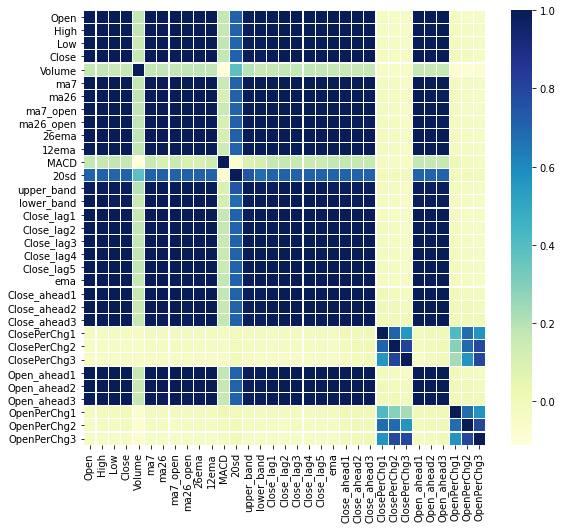

In [11]:
import seaborn as sns 
from scipy.stats import norm 

df_A_ti = get_technical_indicators(df_A)
#df_A_ti = df_A_ti.dropna()

corrmat = df_A_ti.corr() 
  
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 

In [12]:
#df_A_ti = get_technical_indicators(df_A)
#df_A_ti = df_A_ti.dropna()
#df_A_ti = df_A_ti[5:]
#df_A_ti = df_A_ti.fillna(method='backfill')
df_A_ti = df_A_ti.fillna(method='backfill')
df_A_ti = df_A_ti.dropna()
df_A_y = df_A_ti.copy()

#df_A_y['Per'] = (df_A_y['Close_lag1'] - df_A_y['Close'])/ df_A_y['Close_lag1'] )*100
df_A_y = df_A_y[['OpenPerChg1','ClosePerChg1','OpenPerChg2','ClosePerChg2','OpenPerChg3','ClosePerChg3']]
#df_A_ti = df_A_ti[5:]
df_A_ti = df_A_ti[['Open','Close','High', 'Low','Volume','20sd','MACD']]
#,'Close_lag1','Close_lag2','Close_lag3','Close_lag4','Close_lag5'
#,'Adj Close','VIX_Open','VIX_High','VIX_Low','VIX_Close','VIX_Adj Close'
 #,'VIX_20sd','upper_band','lower_band']]#,'VIX_Open','VIX_High','VIX_Low','VIX_Close']]


In [13]:
df_A_ti.isna().any()
df_A_y.isna().any()

OpenPerChg1     False
ClosePerChg1    False
OpenPerChg2     False
ClosePerChg2    False
OpenPerChg3     False
ClosePerChg3    False
dtype: bool

In [14]:
#from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#plot_acf(df_A_ti['Close'], lags=50)
#plot_pacf(df_A_ti['Close'], lags=50)

In [15]:
df_A_y

,OpenPerChg1,ClosePerChg1,OpenPerChg2,ClosePerChg2,OpenPerChg3,ClosePerChg3
Date,,,,,,
2013-01-02,0.004647,0.004547,0.005858,0.007151,0.026906,0.043333
2013-01-03,0.001205,0.002592,0.022156,0.038610,0.038092,0.030563
2013-01-04,0.020926,0.035925,0.036843,0.027899,0.041114,0.027783
2013-01-07,0.015591,-0.007748,0.019774,-0.007860,0.021181,-0.011622
2013-01-08,0.004119,-0.000113,0.005504,-0.003904,-0.007376,0.005856
...,...,...,...,...,...,...
2019-12-17,0.009567,-0.003703,0.001400,0.000905,0.012154,-0.002323
2019-12-18,-0.008089,0.004624,0.002563,0.001384,-0.003766,0.005028
2019-12-19,0.010739,-0.003225,0.004358,0.000402,0.007475,-0.001713


In [16]:
args = df_A_ti.values.reshape(df_A_ti.shape[0],7)
args_y = df_A_y.values.reshape(df_A_y.shape[0],6)

In [17]:
in_seq1 = args
in_seq1_y= args_y

In [18]:
#x_scaler = MinMaxScaler().fit(args)
#X= x_scaler.transform(args)
print(in_seq1.shape)
print(in_seq1_y.shape)

(1757, 7)
(1757, 6)


In [19]:
division = int(len(in_seq1) *8/10)

data_train = in_seq1[:division]
data_test = in_seq1[(division-lookback_days):]

data_train_y= in_seq1_y[:division]
data_test_y = in_seq1_y[(division-lookback_days):]

In [20]:
def split_sequences(sequences, sequences_y,  n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences_y[end_ix-1:end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [21]:
X_train,y_train = split_sequences(data_train, data_train_y, lookback_days, forward_days)

In [22]:
y_train.shape

(1376, 1, 6)

In [23]:
X_features = X_train.shape[2]
y_features = y_train.shape[2]

In [24]:
X_train=X_train.reshape(X_train.shape[0],lookback_days*X_features)
y_train=y_train.reshape(y_train.shape[0],y_features)

In [25]:
X_train.shape

(1376, 210)

In [26]:
x_scaler = MinMaxScaler()#.fit(X_train)
#x_scaler = RobustScaler(quantile_range = (0.05,0.95))
#x_scaler.fit(X_train)
#X_train = x_scaler.transform(X_train)

In [27]:
smoothing_window_size = 500
for di in range(0,1000,smoothing_window_size):
    x_scaler.fit(X_train[di:di+smoothing_window_size,:])
    X_train[di:di+smoothing_window_size,:] = x_scaler.transform(X_train[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
x_scaler.fit(X_train[di+smoothing_window_size:,:])
X_train[di+smoothing_window_size:,:] = x_scaler.transform(X_train[di+smoothing_window_size:,:])

In [28]:
y_scaler = MinMaxScaler(feature_range=(0, 1))#.fit(y_train)
#y_scaler = RobustScaler(quantile_range = (0.05,0.95))
#y_scaler.fit(y_train)
#y_train = y_scaler.transform(y_train)

In [29]:
# smoothing_window_size = 500
# for di in range(0,1000,smoothing_window_size):
#     y_scaler.fit(y_train[di:di+smoothing_window_size,:])
#     y_train[di:di+smoothing_window_size,:] = y_scaler.transform(y_train[di:di+smoothing_window_size,:])

# # You normalize the last bit of remaining data
# y_scaler.fit(y_train[di+smoothing_window_size:,:])
# y_train[di+smoothing_window_size:,:] = y_scaler.transform(y_train[di+smoothing_window_size:,:])

In [30]:
#y_scaler = StandardScaler()
y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)

<function matplotlib.pyplot.show>

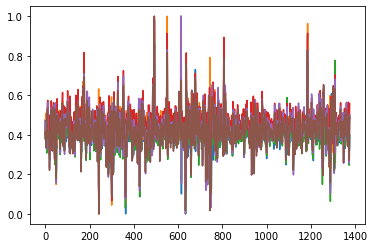

In [31]:
#plt.plot(X_train)
plt.plot(y_train)
plt.show

In [32]:
X_train = X_train.reshape(X_train.shape[0], lookback_days, X_features)
#y_train = y_train.reshape(y_train.shape[0], forward_days,y_features )

# Loss and Attention layer

In [33]:
from tensorflow.keras import backend as K
class attention(tf.keras.layers.Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

    # def get_config(self):
    #     config = super().get_config().copy()
    #     config.update({
    #         'return_sequences': self.return_sequences 
    #     })
    #     return config

In [34]:
def customLoss(ytrue,ypred):  
    diff = ypred - ytrue
    upperband = K.less(tf.cast(ytrue, dtype=tf.float32, name=None),tf.constant(0.6))
    
    upperband = K.cast(upperband, K.floatx()) #1 for lower, 0 for greater
    # print(upper
    p_upperband = K.less(tf.cast(ypred, dtype=tf.float32, name=None),tf.constant(0.6))
    
    p_upperband = K.cast(p_upperband, K.floatx()) #1 for lower, 0 for greater
    lowerband = K.greater(tf.cast(ytrue, dtype=tf.float32, name=None),tf.constant(0.2))
    lowerband = K.cast(lowerband, K.floatx()) #0 for lower, 1 for greater
    
    p_lowerband = K.greater(tf.cast(ypred, dtype=tf.float32, name=None),tf.constant(0.2))
    p_lowerband = K.cast(p_lowerband, K.floatx()) #0 for lower, 1 for greater

    ub_check = K.not_equal(upperband,p_upperband)
    ub_check = K.cast(ub_check, K.floatx())
    ub_check = ub_check + 1
    lb_check = K.not_equal(lowerband,p_lowerband)
    lb_check = K.cast(lb_check, K.floatx())
    lb_check = lb_check + 1
    band = K.equal(upperband,lowerband)
    band = K.cast(band, K.floatx())
    band = band + 1                 #1 for lower, 2 for greater
    greater = K.greater(tf.abs(diff),tf.constant(0.3))
    greater = K.cast(greater, K.floatx()) #0 for lower, 1 for greater
    greater = greater + 1                 #1 for lower, 2 for greater

    #use some kind of loss here, such as mse or mae, or pick one from keras
    #using mse:
    return (ub_check * lb_check * band * greater * K.square(diff))

# Model

In [35]:
model = Sequential()
model.add((Conv1D(filters=32, kernel_size=5, activation='relu',
                                 input_shape=(30,7))))
model.add((MaxPooling1D(pool_size=2)))
model.add(Bidirectional(LSTM(100, return_sequences=True,#input_shape=(30,7),
              activation='tanh', recurrent_activation='hard_sigmoid',kernel_initializer='random_uniform')))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=True,
              activation='relu', recurrent_activation='hard_sigmoid',kernel_initializer='random_uniform')))
model.add(Dropout(0.5))

model.add(attention(return_sequences=False))
model.add((Dense(6)))
opt = Adam(lr=0.001)
#model = tf.keras.models.load_model('my_model', custom_objects={'customLoss':customLoss})
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',  patience=30)
#mc = tf.keras.callbacks.ModelCheckpoint( 'model.h5' ,monitor='val_loss', mode='min',  save_best_only=True )
model.compile(optimizer=opt, loss=[customLoss], metrics=[customLoss,'mse','mae','mape'])

In [36]:
batch_size = 32
model.fit(np.asarray(X_train).astype(np.float32), np.asarray(y_train).astype(np.float32), epochs=150, verbose=1 , shuffle=True,
      callbacks=[es], batch_size=batch_size, validation_split=0.2)

Epoch 1/150
35/35 [==============================] - 44s 179ms/step - loss: 0.6242 - customLoss: 0.6242 - mse: 0.0883 - mae: 0.2510 - mape: 263872.0465 - val_loss: 0.0366 - val_customLoss: 0.0366 - val_mse: 0.0136 - val_mae: 0.0888 - val_mape: 22.5469
Epoch 2/150
35/35 [==============================] - 5s 151ms/step - loss: 0.0260 - customLoss: 0.0260 - mse: 0.0107 - mae: 0.0778 - mape: 309401.8214 - val_loss: 0.0265 - val_customLoss: 0.0265 - val_mse: 0.0104 - val_mae: 0.0752 - val_mape: 19.6663
Epoch 3/150
35/35 [==============================] - 5s 154ms/step - loss: 0.0262 - customLoss: 0.0262 - mse: 0.0101 - mae: 0.0722 - mape: 240740.5219 - val_loss: 0.0208 - val_customLoss: 0.0208 - val_mse: 0.0085 - val_mae: 0.0662 - val_mape: 17.2201
Epoch 4/150
35/35 [==============================] - 5s 154ms/step - loss: 0.0185 - customLoss: 0.0185 - mse: 0.0079 - mae: 0.0657 - mape: 184787.2402 - val_loss: 0.0184 - val_customLoss: 0.0184 - val_mse: 0.0074 - val_mae: 0.0611 - val_mape: 15.

In [37]:
model.save('my_model') 

INFO:tensorflow:Assets written to: my_model/assets


# Testing

In [38]:
y_train.max(),y_train.min()

(1.0000000000000002, 0.0)

In [39]:
X_test, y_test = split_sequences(data_test, data_test_y, lookback_days,forward_days)
X_test_original = X_test

In [40]:
X_test=X_test.reshape(X_test.shape[0],lookback_days*X_features)
y_test=y_test.reshape(y_test.shape[0],y_features)

In [41]:
xtest_scaler = MinMaxScaler().fit(X_test)
X_test = xtest_scaler.transform(X_test)
ytest_scaler = MinMaxScaler(feature_range=(0, 1)).fit(y_test)
#y_scaler.fit(y_test)
y_test = ytest_scaler.transform(y_test)

In [42]:
X_test = X_test.reshape(X_test.shape[0],lookback_days, X_features)
#y_test = y_test.reshape(y_test.shape[0],forward_days, y_features)

In [43]:
y_pred = model.predict(X_test,batch_size = 16)

In [44]:
evaluation = model.evaluate(X_test, y_test)
print(evaluation) #'mse','mae', 'mape'

12/12 [==============================] - 0s 11ms/step - loss: 0.0946 - customLoss: 0.0946 - mse: 0.0348 - mae: 0.1545 - mape: 1160387.8750
[0.09457249194383621, 0.09457249939441681, 0.03475010022521019, 0.15450230240821838, 1160387.875]


In [45]:
y_pred = y_pred.reshape(y_pred.shape[0],y_features)
y_pred = ytest_scaler.inverse_transform(y_pred)

In [46]:
#y_pred = y_pred.reshape(y_pred.shape[0],forward_days,y_features)

In [47]:
y_test = y_test.reshape(y_test.shape[0],y_features)
#y_true = y_test
y_true = ytest_scaler.inverse_transform(y_test)

In [48]:
X_test = X_test.reshape(X_test.shape[0],lookback_days*X_features)
X_test = xtest_scaler.inverse_transform(X_test)
#y_true = y_true.reshape(y_true.shape[0],forward_days,y_features)

In [49]:
diff_true = array([y_true[:,x] - X_test_original[:,0,-1] for x in [0,1,2,3,4,5]])
diff_pred = array([y_pred[:,x] - X_test_original[:,0,-1] for x in [0,1,2,3,4,5]])

In [50]:
diff_true1 = array([y_true[:,x] - X_test_original[:,1,-1] for x in [1,3,5]])
diff_true2 = array([y_true[:,x] - X_test_original[:,0,-1] for x in [0,2,4]])
diff_true=np.concatenate((diff_true1,diff_true2),axis=1)

In [51]:
diff_pred1 = array([y_pred[:,x] - X_test_original[:,1,-1] for x in [1,3,5]])
diff_pred2 = array([y_pred[:,x] - X_test_original[:,0,-1] for x in [0,2,4]])
diff_pred=np.concatenate((diff_pred1,diff_pred2),axis=1)

In [52]:
def rsquared(y, y_hat):
    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

In [53]:
y_bar = y_true.mean()
ss_tot = ((y_true-y_bar)**2).sum()
ss_res = ((y_true-y_pred)**2).sum()
print(ss_res)
print(ss_tot)

y_bar = diff_true.mean()
ss_tot = ((diff_true-y_bar)**2).sum()
ss_res = ((diff_true-diff_pred)**2).sum()
print(ss_res)
print(ss_tot)

3.49191569589461
1.5571794546355493
3.491915695894612
2051624.0413665138


In [54]:
import sklearn.metrics as metrics
mae = metrics.mean_absolute_error(y_true, y_pred)
mse = metrics.mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse) #mse**(0.5)  
r2 = rsquared(y_true, y_pred)
mae_diff = metrics.mean_absolute_error(diff_true, diff_pred)
mse_diff = metrics.mean_squared_error(diff_true, diff_pred)
rmse_diff = np.sqrt(mse_diff) #mse**(0.5)  
r2_diff = rsquared(diff_true, diff_pred)
print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)
print("MAE_diff:",mae_diff)
print("MSE_diff:", mse_diff)
print("RMSE_diff:", rmse_diff)
print("R-Squared diff:", r2_diff)

Results of sklearn.metrics:
MAE: 0.03327323669561163
MSE: 0.0016486854088265388
RMSE: 0.04060400730009957
R-Squared: -1.2424619625564461
MAE_diff: 0.033273236695611635
MSE_diff: 0.00164868540882654
RMSE_diff: 0.04060400730009958
R-Squared diff: 0.9999982979748602


In [55]:
y_pred_len = y_pred.shape[0]

In [56]:
dataset_prev = pd.DataFrame({
    'open': X_test_original[:,-1,0],'close': X_test_original[:,-1,1]
                        })
dataset_per = pd.DataFrame({
    'open1PerChg': y_pred[:,0], 'close1PerChg': y_pred[:,1],
    'open2PerChg': y_pred[:,2], 'close2PerChg': y_pred[:,3],
    'open3PerChg': y_pred[:,4], 'close3PerChg': y_pred[:,5]
                         })
datasetarray = pd.DataFrame({
    'open1': y_pred[:,0], 'close1': y_pred[:,1]        ,
    'open2': y_pred[:,2], 'close2': y_pred[:,3]  ,
    'open3': y_pred[:,4], 'close3': y_pred[:,5]                 })

datasetarray['open1'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_per['open1PerChg'])
datasetarray['open2'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_per['open2PerChg'])
datasetarray['open3'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_per['open3PerChg'])
datasetarray['close1'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_per['close1PerChg'])
datasetarray['close2'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_per['close2PerChg'])
datasetarray['close3'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_per['close3PerChg'])

dataset_trueper = pd.DataFrame({
    'open1PerChg': y_true[:,0], 'close1PerChg': y_true[:,1],
    'open2PerChg': y_true[:,2], 'close2PerChg': y_true[:,3],
    'open3PerChg': y_true[:,4], 'close3PerChg': y_true[:,5]
                         })
dataset_truearray = pd.DataFrame({
    'open1': y_true[:,0], 'close1': y_true[:,1]        ,
    'open2': y_true[:,2], 'close2': y_true[:,3]  ,
    'open3': y_true[:,4], 'close3': y_true[:,5]                 })

dataset_truearray['open1'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_trueper['open1PerChg'])
dataset_truearray['open2'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_trueper['open2PerChg'])
dataset_truearray['open3'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_trueper['open3PerChg'])
dataset_truearray['close1'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_trueper['close1PerChg'])
dataset_truearray['close2'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_trueper['close2PerChg'])
dataset_truearray['close3'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_trueper['close3PerChg'])


In [57]:
# dataset1 = dataset[:-3][['open','close']]
# dataset_true1 = dataset_true[:-1][['open','close']]
# datasetarray = dataset1.values.reshape(dataset1.shape[0],2)
datasetarray = datasetarray[:-3]
datasetarray = np.asarray(datasetarray).astype(np.float32)
# dataset_truearray = dataset_true1.values.reshape(dataset_true1.shape[0],2)
dataset_truearray = dataset_truearray[:-3]
dataset_truearray = np.asarray(dataset_truearray).astype(np.float32)


In [58]:
import sklearn.metrics as metrics
mae = metrics.mean_absolute_error(datasetarray, dataset_truearray)
mse = metrics.mean_squared_error(datasetarray, dataset_truearray)
rmse = np.sqrt(mse) #mse**(0.5)  
r2 = rsquared(datasetarray, dataset_truearray)
print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 58.3264
MSE: 4904.166
RMSE: 70.029755
R-Squared: 0.6908219158649445


In [59]:
dataset_prev = pd.DataFrame({
    'open': X_test_original[:,-1,0],'close': X_test_original[:,-1,1]
                        })
dataset_per = pd.DataFrame({
    'openPerChg': y_pred[:,0], 'closePerChg': y_pred[:,1]
                         })
dataset = pd.DataFrame({
    'open': y_pred[:,0], 'close': y_pred[:,1]                       })
dataset['open'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_per['openPerChg'])
dataset['close'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_per['closePerChg'])

dataset_trueper = pd.DataFrame({
    'openPerChg': y_true[:,0], 'closePerChg': y_true[:,1]
                        })
dataset_true = pd.DataFrame({
    'open': y_pred[:,0], 'close': y_pred[:,1]                       })
dataset_true['open'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_trueper['openPerChg'])
dataset_true['close'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_trueper['closePerChg'])


dataset.loc[:,'date'] = pd.to_datetime(df_A[-y_pred_len-2:-2].index)
dataset_true.loc[:,'date'] = pd.to_datetime(df_A[-y_pred_len-2:-2].index)

In [60]:
dataset=dataset.assign(low=lambda d: d[['open', 'close']].min(1))
dataset=dataset.assign(high=lambda d: d[['open', 'close']].max(1))
dataset_true=dataset_true.assign(low=lambda d: d[['open', 'close']].min(1))
dataset_true=dataset_true.assign(high=lambda d: d[['open', 'close']].max(1))

In [61]:
%pip install https://github.com/matplotlib/mpl_finance/archive/master.zip

     | 399kB 4.7MB/s
  Created wheel for mpl-finance: filename=mpl_finance-0.10.1-cp37-none-any.whl size=8424 sha256=609cfa095fc674a04ce4fdc69e554881e08ca35b117bc1e6a69e9128fe7afb04
  Stored in directory: /tmp/pip-ephem-wheel-cache-glb8treq/wheels/8f/bf/8a/6c858b2a3be945c7b2d658fbf6ab797b451d686cbee8aa2679
Successfully built mpl-finance


In [62]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import datetime as dt
import mpl_finance as mpf 

In [63]:
import plotly.graph_objects as go

fig = go.Figure(data=
                [go.Ohlc(x=dataset['date'],
                open=dataset['open'],
                high=dataset['high'],
                low=dataset['low'],
                close=dataset['close'],
                showlegend=False,
                name="predicted"),
                 go.Ohlc(x=dataset_true['date'],
                open=dataset_true['open'],
                high=dataset_true['high'],
                low=dataset_true['low'],
                close=dataset_true['close'],
                showlegend=False,
                name="true",
    increasing_line_color= 'cyan', decreasing_line_color= 'gray'
)])
fig.update_layout(
    autosize=False,
    width=1000,
    height=800,)
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

# EVALUATION

In [64]:
%pip install yfinance

In [65]:
import yfinance as yf
ticker = 'GOOG'
index = yf.Ticker(ticker)

# get historical market data
hist = index.history(start='2020-06-01', end= '2020-12-30', actions=False)

In [66]:
def test_data_prediction(df_test):
  #df_test['Date'] = pd.to_datetime(df_test['Date'])
  #df_test.set_index('Date', inplace=True)



  df_test_ti = get_technical_indicators(df_test)
  #df_test_ti = df_test_ti.dropna()
  df_test = df_test.fillna(method='backfill')
  #df_test_ti = df_test_ti.dropna()
  df_test_y = df_test.copy()
  df_test_y = df_test_y[['OpenPerChg1','ClosePerChg1','OpenPerChg2','ClosePerChg2','OpenPerChg3','ClosePerChg3']]
  df_test_ti = df_test_ti[['Open','Close','High', 'Low','Volume','20sd','MACD']]

  args_test = df_test_ti.values.reshape(df_test_ti.shape[0],7)
  args_test_y = df_test_y.values.reshape(df_test_y.shape[0],6)

  in_seq_test = args_test
  in_seq_test_y = args_test_y

  division =  35

  data_train = in_seq_test[:division]
  data_test = in_seq_test[(division-lookback_days):]

  data_train_y = in_seq_test_y[:division]
  data_test_y = in_seq_test_y[(division-lookback_days):]

  X_test, y_test = split_sequences(data_test, data_test_y, lookback_days,forward_days)

  X_features = X_test.shape[2]
  y_features = y_test.shape[2]
  X_test_original = X_test
  X_test=X_test.reshape(X_test.shape[0],lookback_days*X_features)
  y_test=y_test.reshape(y_test.shape[0],y_features)

  xtest_scaler = MinMaxScaler().fit(X_test)
  X_test = xtest_scaler.transform(X_test)
  ytest_scaler = MinMaxScaler().fit(y_test)
  #y_scaler.fit(y_test)
  y_test = ytest_scaler.transform(y_test)

  X_test = X_test.reshape(X_test.shape[0],lookback_days, X_features)

  y_pred = model.predict(X_test,batch_size = 16)
  y_pred = y_pred.reshape(y_pred.shape[0],y_features)
  y_hat = ytest_scaler.inverse_transform(y_pred)

  y_test = y_test.reshape(y_test.shape[0],y_features)
  #y_true = y_test
  y_true = ytest_scaler.inverse_transform(y_test)

  return y_test,y_true,y_pred,y_hat,X_test_original

In [67]:
y_test1,y_true1,y_pred1,y_hat1,X_test_original1 = test_data_prediction(hist)

In [68]:
y_test=y_test1
y_true=y_true1
y_pred=y_pred1
y_hat=y_hat1
X_test_original = X_test_original1

In [69]:
diff_true = array([y_true[:,x] - X_test_original[:,0,-1] for x in [0,1,2,3,4,5]])
diff_pred = array([y_hat[:,x] - X_test_original[:,0,-1] for x in [0,1,2,3,4,5]])

In [70]:
#diff_pred[diff_pred<0] = - diff_pred[diff_pred<0]
#diff_true[diff_true<0] = - diff_true[diff_true<0]

In [71]:
import sklearn.metrics as metrics
mae = metrics.mean_absolute_error(y_true[:-3], y_hat[:-3])
mse = metrics.mean_squared_error(y_true[:-3], y_hat[:-3])
rmse = np.sqrt(mse) #mse**(0.5)  
r2 = rsquared(y_true[:-3], y_hat[:-3])

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 0.025095574612852473
MSE: 0.0011261139624003339
RMSE: 0.03355762152477934
R-Squared: -0.6713742143779415


In [72]:
y_pred=y_hat
y_pred_len = y_pred.shape[0]

In [73]:
new_row1 = {'open':y_pred[-2,2] , 'close':y_pred[-2,3]}
new_row2 = {'open':y_pred[-1,4] , 'close':y_pred[-1,4]}

In [74]:
from datetime import timedelta
dataset_prev = pd.DataFrame({
    'open': X_test_original[:,-1,0],'close': X_test_original[:,-1,1]
                        })
dataset_per = pd.DataFrame({
    'openPerChg': y_pred[:,0], 'closePerChg': y_pred[:,1]
                         })
dataset = pd.DataFrame({
    'open': y_pred[:,0], 'close': y_pred[:,1]                       })
dataset['open'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_per['openPerChg'])
dataset['close'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_per['closePerChg'])

dataset_trueper = pd.DataFrame({
    'openPerChg': y_true[:,0], 'closePerChg': y_true[:,1]
                        })
dataset_true = pd.DataFrame({
    'open': y_pred[:,0], 'close': y_pred[:,1]                       })
dataset_true['open'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_trueper['openPerChg'])
dataset_true['close'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_trueper['closePerChg'])


new_row1 = {'open':X_test_original[-1,-1,0] + (X_test_original[-1,-1,0] * y_pred[-1,2]),
            'close':X_test_original[-1,-1,1] + (X_test_original[-1,-1,1] * y_pred[-1,3])}
new_row2 = {'open':X_test_original[-1,-1,0] + (X_test_original[-1,-1,0] * y_pred[-1,4]) , 
            'close':X_test_original[-1,-1,1] + (X_test_original[-1,-1,1] * y_pred[-1,5])}

tempDf = pd.to_datetime(hist[-y_pred_len:].index)
dataset.loc[:,'date'] = pd.to_datetime(hist[-y_pred_len:].index)
dataset_true.loc[:,'date'] = pd.to_datetime(hist[-y_pred_len:].index)

dataset = dataset.append(new_row1, ignore_index=True)
dataset = dataset.append(new_row2, ignore_index=True)
dataset.loc[y_pred_len,'date'] = pd.to_datetime(tempDf[-1] + timedelta(days=1))
dataset.loc[y_pred_len+1,'date'] = pd.to_datetime(tempDf[-1] + timedelta(days=2))

In [75]:
dataset_prev = pd.DataFrame({
    'open': X_test_original[:,-1,0],'close': X_test_original[:,-1,1]
                        })
                        
dataset_per = pd.DataFrame({
    'open1PerChg': y_pred[:,0], 'close1PerChg': y_pred[:,1],
    'open2PerChg': y_pred[:,2], 'close2PerChg': y_pred[:,3],
    'open3PerChg': y_pred[:,4], 'close3PerChg': y_pred[:,5]
                         })
datasetarray = pd.DataFrame({
    'open1': y_pred[:,0], 'close1': y_pred[:,1]        ,
    'open2': y_pred[:,2], 'close2': y_pred[:,3]  ,
    'open3': y_pred[:,4], 'close3': y_pred[:,5]                 })

datasetarray['open1'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_per['open1PerChg'])
datasetarray['open2'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_per['open2PerChg'])
datasetarray['open3'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_per['open3PerChg'])
datasetarray['close1'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_per['close1PerChg'])
datasetarray['close2'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_per['close2PerChg'])
datasetarray['close3'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_per['close3PerChg'])

dataset_trueper = pd.DataFrame({
    'open1PerChg': y_true[:,0], 'close1PerChg': y_true[:,1],
    'open2PerChg': y_true[:,2], 'close2PerChg': y_true[:,3],
    'open3PerChg': y_true[:,4], 'close3PerChg': y_true[:,5]
                         })
dataset_truearray = pd.DataFrame({
    'open1': y_true[:,0], 'close1': y_true[:,1]        ,
    'open2': y_true[:,2], 'close2': y_true[:,3]  ,
    'open3': y_true[:,4], 'close3': y_true[:,5]                 })

dataset_truearray['open1'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_trueper['open1PerChg'])
dataset_truearray['open2'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_trueper['open2PerChg'])
dataset_truearray['open3'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_trueper['open3PerChg'])
dataset_truearray['close1'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_trueper['close1PerChg'])
dataset_truearray['close2'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_trueper['close2PerChg'])
dataset_truearray['close3'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_trueper['close3PerChg'])


In [76]:
# dataset1 = dataset[:-3][['open','close']]
# dataset_true1 = dataset_true[:-1][['open','close']]
# datasetarray = dataset1.values.reshape(dataset1.shape[0],2)
datasetarray = datasetarray[:-3]
datasetarray = np.asarray(datasetarray).astype(np.float32)
# dataset_truearray = dataset_true1.values.reshape(dataset_true1.shape[0],2)
dataset_truearray = dataset_truearray[:-3]
dataset_truearray = np.asarray(dataset_truearray).astype(np.float32)


In [77]:
import sklearn.metrics as metrics
mae = metrics.mean_absolute_error(datasetarray, dataset_truearray)
mse = metrics.mean_squared_error(datasetarray, dataset_truearray)
rmse = np.sqrt(mse) #mse**(0.5)  
r2 = rsquared(datasetarray, dataset_truearray)
print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 40.11948
MSE: 2856.9883
RMSE: 53.4508
R-Squared: 0.8017612099647522


In [78]:
'''Results of sklearn.metrics:
MAE: 99.565636
MSE: 13574.67
RMSE: 116.51038
R-Squared: 0.8122207224369049

MAE: 35.6758
MSE: 2044.9722
RMSE: 45.221367
R-Squared: 0.8556911498308182'''

'Results of sklearn.metrics:\nMAE: 99.565636\nMSE: 13574.67\nRMSE: 116.51038\nR-Squared: 0.8122207224369049\n\nMAE: 35.6758\nMSE: 2044.9722\nRMSE: 45.221367\nR-Squared: 0.8556911498308182'

In [79]:
dataset=dataset.assign(low=lambda d: d[['open', 'close']].min(1))
dataset=dataset.assign(high=lambda d: d[['open', 'close']].max(1))
dataset_true=dataset_true.assign(low=lambda d: d[['open', 'close']].min(1))
dataset_true=dataset_true.assign(high=lambda d: d[['open', 'close']].max(1))

In [80]:
import plotly.graph_objects as go

import pandas as pd
from datetime import datetime

fig = go.Figure(data=
                [go.Ohlc(x=dataset['date'],
                open=dataset['open'],
                high=dataset['high'],
                low=dataset['low'],
                close=dataset['close'],
                showlegend=False,
                name="predicted"),
                 go.Ohlc(x=dataset_true['date'],
                open=dataset_true['open'],
                high=dataset_true['high'],
                low=dataset_true['low'],
                close=dataset_true['close'],
                showlegend=False,
                name="true",
    increasing_line_color= 'blue', decreasing_line_color= 'yellow'
)])
fig.update_layout(
    autosize=False,
    width=1000,
    height=800,)
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()


In [81]:
!zip -r /content/my_model.zip /content/my_model

from google.colab import files
#files.download("/content/my_model.zip")

  adding: content/my_model/ (stored 0%)
  adding: content/my_model/saved_model.pb (deflated 90%)
  adding: content/my_model/assets/ (stored 0%)
  adding: content/my_model/variables/ (stored 0%)
  adding: content/my_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/my_model/variables/variables.index (deflated 70%)


In [82]:
#files.download("/content/my_model.zip")